# Comptage photometrique

- auteur : Sylvie Dagoret-Campagne
- date de creation : 8 juin 2021
- update : 9 juin 2021
- affiliation : IJCLab/IN2P3/CNRS


L'objectif de ce notebook est de comparer le nombre de photoelectrons prédit par PySynphot par rapport au nombre
de photoelectrons calculés dans la note LSE 40 " The LSST Photon Rates and SNR Calculations" pour vérifier
que Pysynphot est bien calibré.

- On considère les photoelectrons de bruit de fond de ciel
- Les photoelectrons d'une source de magnitude m= 25 au seuil de photo-detection

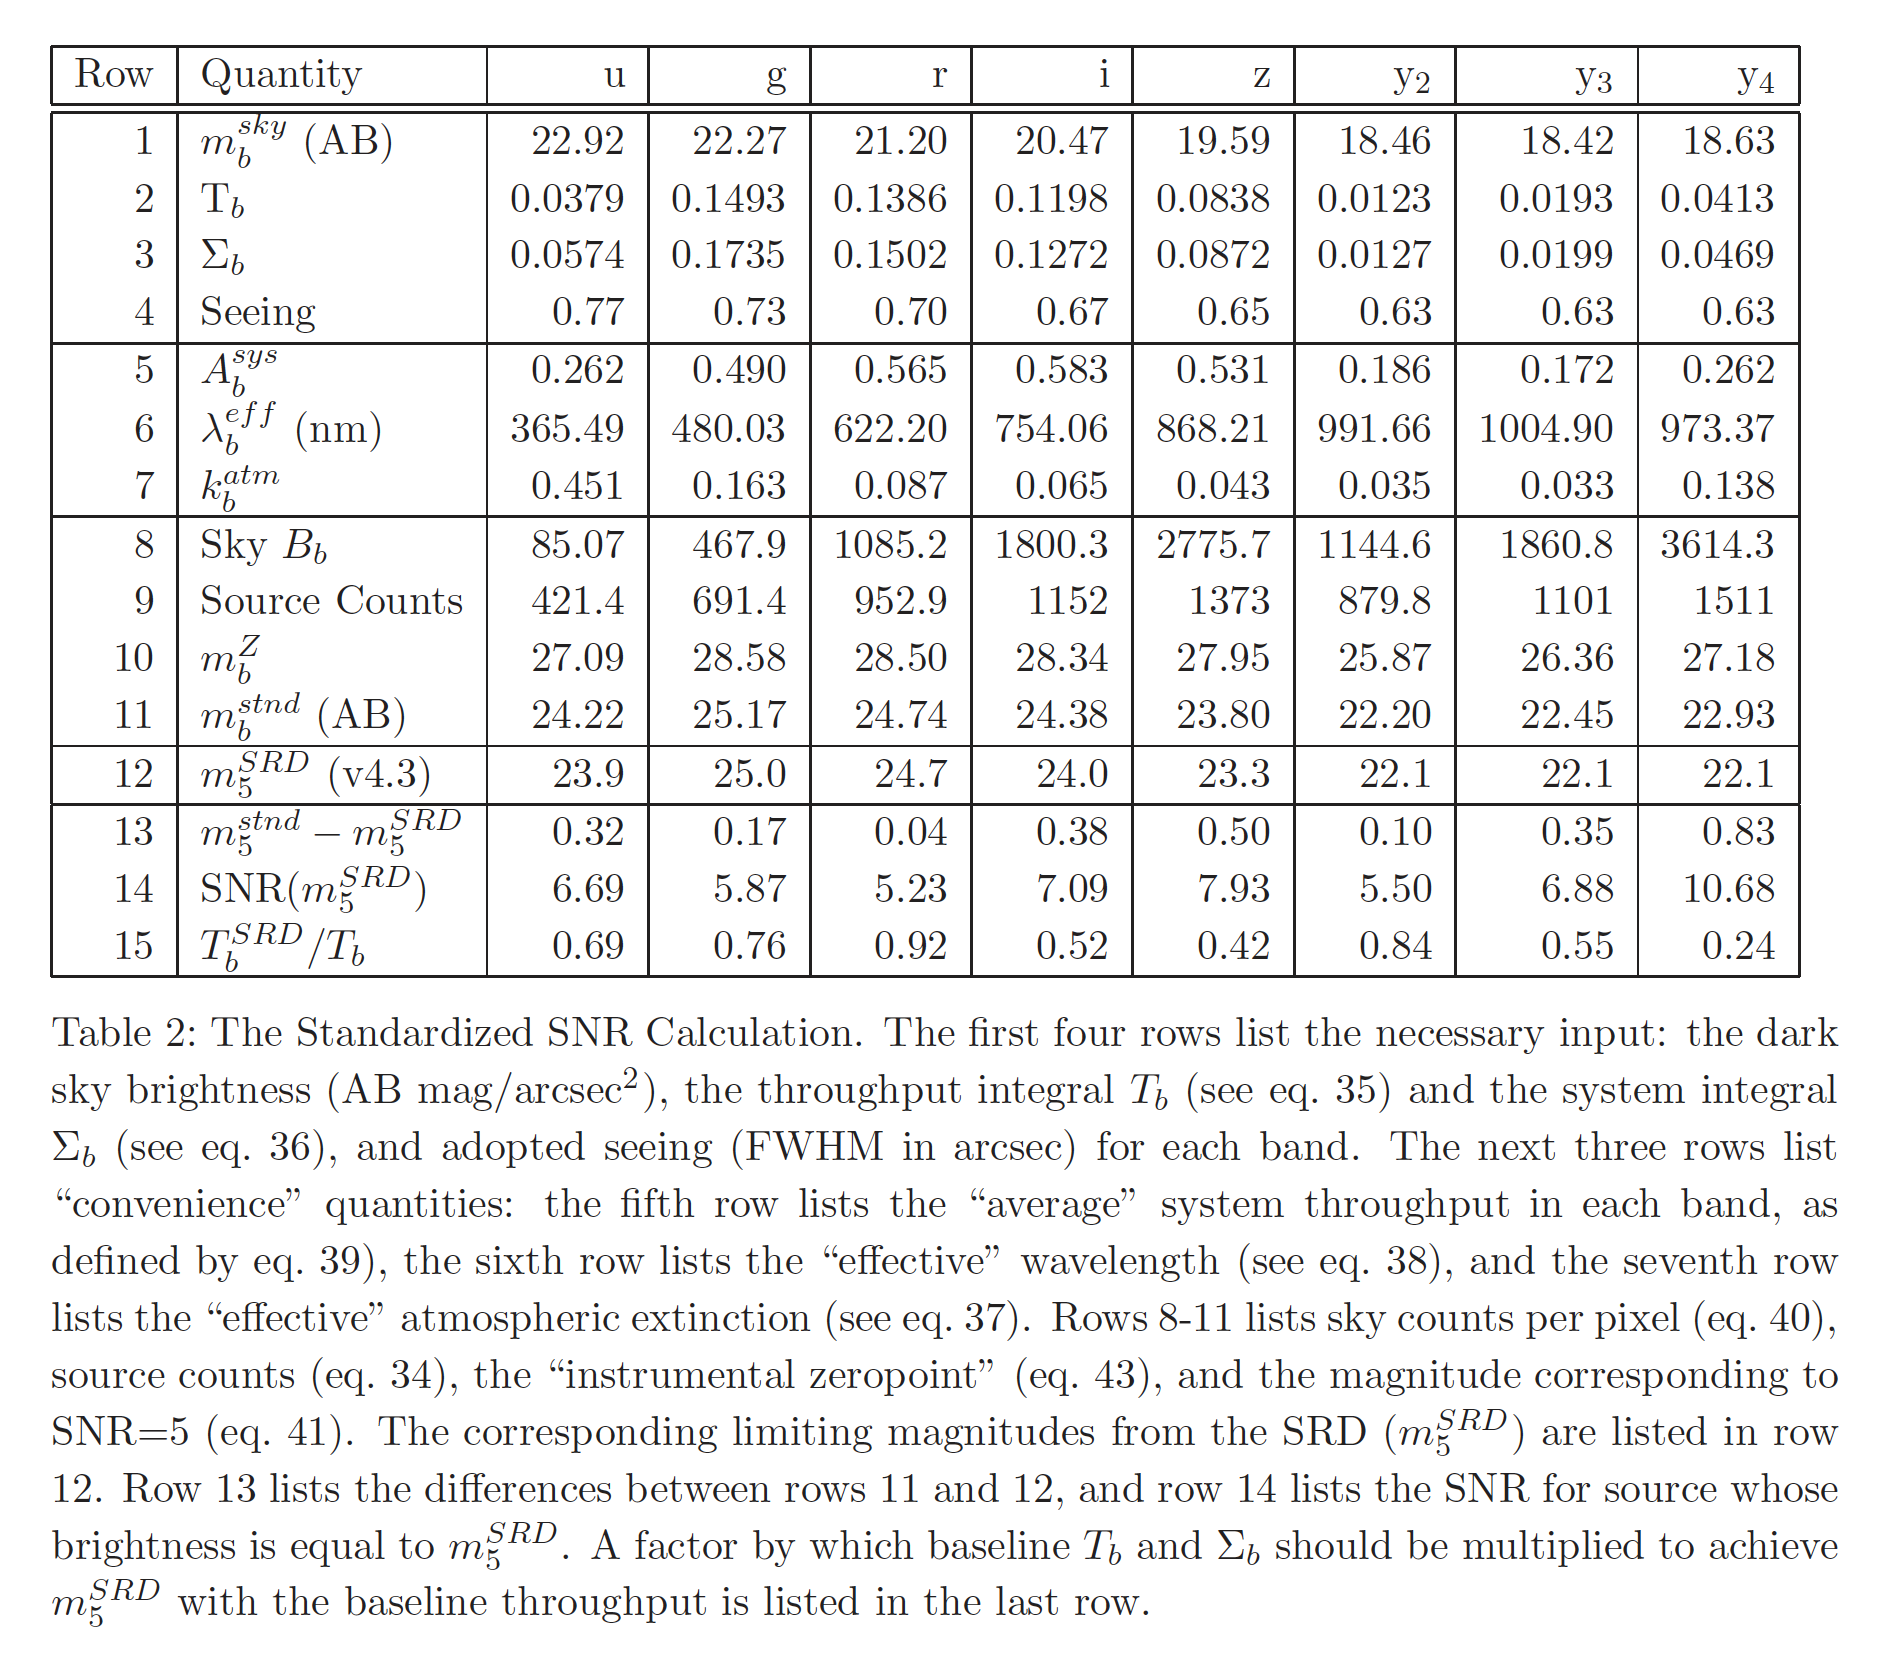

In [1]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "../../Notes/images/LSE-40_Table2.png", width = 800, height = 400)

## Import


In [2]:
import os
from astropy import constants as const

In [3]:
#from astropy import physical_constants, astronomical_constants

In [4]:
from astropy import units as u

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import pysynphot as S

In [7]:
NBBANDS = 6
band_to_number = {'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2 = {'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
number_to_band_2 = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
filtercolor = ['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color = {0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number = {'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col = ['b','g','r','y','grey','k']

WLMIN = 3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX = 11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS = int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth = (WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL = np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff = 642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area = Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave = WLMIN, maxwave = WLMAX, num = NBINS, delta = BinWidth, log = False)
S.refs.showref()

EXPOSURE=30.0 # seconds
gel=1  # phe/ADU
sig_inst=10 # readout noise
pixScale = 0.2 # arcsec per pixel

pysynphot_root_path = os.environ['PYSYN_CDBS']
path_sed_calspec = os.path.join(pysynphot_root_path,'calspec')

#flatsp = S.FlatSpectrum(10, fluxunits='photlam')
#flatsp.convert('photlam')
#flatsp_norm = flatsp.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
#nbr_filters = 7

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Flux


Par définition le flux de réference donnant une magnitude AB nulle est
$$
F_{ref} = 3631.1 Jy 
$$

avec
$$
1 Jy = 10^{-26} W.Hz^{-1}.m^{-2} = 10^{-23}.erg.cm^{-2} s^{-1} . Hz^{-1}
$$

## Flux de référence

Flux $F(m)$ en $W/Hz/m^2$ pour une magnitude AB $m$.

$
F(m) = 3631.10^{-26}\times 10^{-0.4(m-25)}\times 10^{-10}
$

In [8]:
# Conversion de 1Jy en W/Hz/m2 et on divise par 1O^0.4*25 (unite de 25 mag)
# Calcul dans le SI
K0=3631.1*1e-26*np.power(10,-10.)
K0 # W/Hz/m2

3.6311e-33

In [9]:
# Pour une surface collectrice correspondant à D=6.5 m et Delta t = 30 sec
# K1 est le terme de photoelectrons produits par le CCD pendant Delta T= 30 secondes
# Calcul dans le SI
# Constante de Planch h = 6.62 10-34 J/Hz
K1=K0*np.pi*6.5**2/4*30./6.626e-34
K1 # photoelectrons dans une exposition de 30 seconde dans le telescope de Diametre effectif de 6.5 m

5455.375228093965

- $C_b$ : nombre d'ADU

$$
C_b = \frac{5455}{g} \times 10^{0.4(25-m)} \times \left( \frac{D}{6.5m}\right)^2 \left( \frac{\Delta t}{30s}\right) \int f_\nu(\lambda) S^{atm}(\lambda) S^{syst}_b (\lambda) \frac{d\lambda}{\lambda}
$$

# Paths

In [10]:
path_atmosphere="../../atmosphere/RT_MPL_pp_us_sa_rtvis_z12_wv40_oz30_cld0000.OUT" # airmass z=1.2
path_throughtput="../../throughput/lsst_throughput.csv"

# Charge configuration

##  Bruit de fond de ciel

In [11]:
# ligne 1 de la table 2 du LSE-40
sky_background_mag=[22.92,22.27,21.20,20.47,19.59,18.64]
# ligne 4 de la table 2 du LSE-40
fwhm_seeing_arcsec=[.77,.73,.7,0.67,0.65,0.63]

## Atmosphere

In [12]:
data_atm=np.loadtxt(path_atmosphere)

In [13]:
wl=data_atm[:,0]
trans=data_atm[:,1]
bp_atm = S.ArrayBandpass(wl*10, trans, name = "atmosphere")

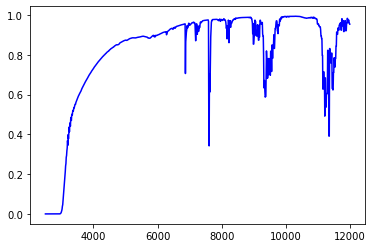

In [14]:
fig,ax= plt.subplots()
wl=bp_atm.wave
tr=bp_atm.throughput
ax.plot(wl,tr,color="b")

## Filtres

In [15]:
df_lsst = pd.read_csv(path_throughtput, index_col=0)
df_lsst

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


In [16]:
bp_filter = []

for index in np.arange(6) :
    filter_name=number_to_band_2[index]
    bp = S.ArrayBandpass(df_lsst["wl"].values*10, df_lsst[filter_name].values, name = filter_name)                      
    bp_filter.append(bp)
    

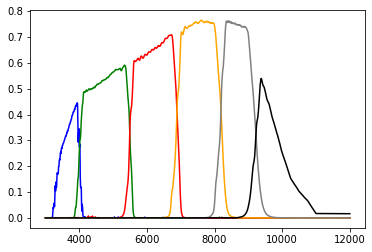

In [17]:
fig,ax=fig, ax = plt.subplots()
for index in np.arange(6) :
    wl=bp_filter[index].wave
    tr=bp_filter[index].throughput
    ax.plot(wl,tr,color=filtercolor[index])

In [18]:
bp_atm_filter = []

for index in np.arange(6) :
    bp=bp_filter[index]*bp_atm
    bp_atm_filter.append(bp)

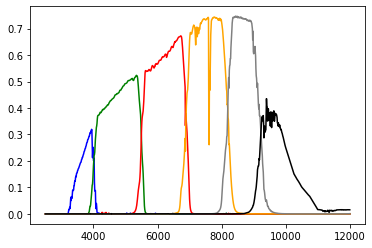

In [19]:
fig,ax=fig, ax = plt.subplots()
for index in np.arange(6) :
    wl=bp_atm_filter[index].wave
    tr=bp_atm_filter[index].throughput
    ax.plot(wl,tr,color=filtercolor[index])

# Tables de LSST

## $T_b$

- ligne 2 de la table 2 de LS40

In [20]:
all_Tb = []
for index in np.arange(6) :
    wl=bp_atm_filter[index].wave
    tr=bp_atm_filter[index].throughput
    
    Tb=np.trapz(tr/wl,x=wl)
    all_Tb.append(Tb)
all_Tb

[0.041773818421693934,
 0.14235168919627506,
 0.13704642378129755,
 0.12438447622919174,
 0.08658012175563427,
 0.043967059336345926]

## $\Sigma_b$

- ligne 3 de la table 2 du LSE-40

In [21]:
all_Sigmab = []
for index in np.arange(6) :
    wl=bp_filter[index].wave
    tr=bp_filter[index].throughput
    
    Sigmab=np.trapz(tr/wl,x=wl)
    all_Sigmab.append(Sigmab)
all_Sigmab

[0.06519157490141832,
 0.17009085002267596,
 0.1501499334793502,
 0.13221588235448126,
 0.09018652398454385,
 0.049794460496103685]

## $k_batm$

- ligne 7 de la table 2 du LSE-40

In [22]:
kb_atm = []
for index in np.arange(6):
    Tb=all_Tb[index]
    Sb=all_Sigmab[index]
    kbatm = -2.5*np.log10(Tb/Sb)
    kb_atm.append(kbatm)
kb_atm

[0.48321824554111936,
 0.19329581628624737,
 0.09914359249248905,
 0.06629361479642462,
 0.04430864057714159,
 0.13513402947853664]

## $\lambda_{eff}$

- ligne 6 de la table 2 du LSE-40

In [23]:
all_lambda_eff = []

for index in np.arange(6):
    wl=bp_filter[index].wave
    Ssyst=bp_filter[index].throughput
    Ssyst_wl = Ssyst*wl
    
    numerator=np.trapz(Ssyst_wl,x=wl)
    denominator=np.trapz(Ssyst,x=wl)
    lambda_eff= numerator/denominator
    
    all_lambda_eff.append(lambda_eff)
    
all_lambda_eff    

[3716.7491938466355,
 4782.948637112553,
 6217.153549377707,
 7540.571056491716,
 8685.833465407366,
 9786.031472947054]

## $A_b$

- ligne 5 de la table 2 du LSE-40

In [24]:
all_Ab = []

for index in np.arange(6):
    wl=bp_filter[index].wave
    Ssyst=bp_filter[index].throughput
    Ssyst_max=np.max(Ssyst)  
    indexes=np.where(Ssyst>0.05*Ssyst_max)[0]
    lambda_B=wl[indexes[0]]
    lambda_R=wl[indexes[-1]]
    D_Lambda=lambda_R-lambda_B
    Sum=np.trapz(Ssyst,x=wl)
    Ab=Sum/D_Lambda
    all_Ab.append(Ab)
all_Ab    

[0.2774047183908046,
 0.47158079824561405,
 0.5596892349397591,
 0.5988297259036144,
 0.5394048827586208,
 0.24537507575757575]

## Nombre de photoelectrons de Bruit de fond de ciel 

- On calcule par pixel. Or une source est typiquement sur 5 x 5 pixels.

In [25]:
all_Bb = []
dt=1.0
for index in np.arange(6): 
    mb_sky = sky_background_mag[index]
    Sigmab = all_Sigmab[index]
    # nombre d'ADU donc nombre de photo-electrons
    # ne pas oublier de convertir Deff en m
    Bb=K1/gel*(Deff/100/6.5)**2*dt/EXPOSURE*(pixScale/1.0)**2*np.power(10,0.4*(25.0-mb_sky))*Sigmab     
    all_Bb.append(Bb)
all_Bb=np.array(all_Bb)


### Nombre de photoelectrons de Bruit de fond de ciel par pixel  par seconde

In [26]:
all_Bb # electrons par pixel par seconde

array([  3.1448792 ,  14.93115645,  35.31324592,  60.91105509,
        93.44458575, 123.76376884])

### Nombre de photoelectrons de Bruit de fond de ciel par pixel par exposition

- Row 8 Table 2 de LSE-40

In [27]:
all_Bb*EXPOSURE

array([  94.34637587,  447.93469363, 1059.39737749, 1827.33165262,
       2803.33757262, 3712.91306524])

##  Nombre de photoelectrons de Bruit de fond de ciel avec PySynPhot par pixel par seconde

In [28]:
all_sky_sed = []
for index in np.arange(6): 
    skybg_mag=sky_background_mag[index]
    flatsp = S.FlatSpectrum(skybg_mag, fluxunits='abmag')*(pixScale/1.0)**2
    all_sky_sed.append(flatsp)

In [29]:
all_obs_sky = []

for index in np.arange(6): 
    obs = S.Observation(all_sky_sed[index],bp_filter[index])    
    all_obs_sky.append(obs)

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [30]:
for index in np.arange(6):
    print(all_obs_sky[index].countrate())

3.1444912526795834
14.929143873795061


/Users/sylvie/anaconda3/lib/python3.8/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


35.30828846508226
60.9031982853436
93.42467497722245
120.16727850360509


## Source Count de magnitude 25

In [31]:
all_Cb = []
mb=25
dt=1.0
for index in np.arange(6): 
    Tb = all_Tb[index]
    # nombre d'ADU donc nombre de photo-electrons
    # ne pas oublier de convertir Deff en m
    Cb=K1/gel*(Deff/100/6.5)**2*dt/EXPOSURE*np.power(10,0.4*(25.0-mb))*Tb     
    all_Cb.append(Cb)
all_Cb=np.array(all_Cb)


### Source Count de magnitude 25 par seconde

In [32]:
all_Cb  #  electrons par seconde

array([ 7.41748502, 25.2763947 , 24.33437579, 22.08608224, 15.3734272 ,
        7.80692348])

### Source Count de magnitude 25 par temps d'exposition

In [33]:
all_Cb* EXPOSURE  

array([222.52455064, 758.29184089, 730.03127369, 662.58246734,
       461.20281593, 234.20770453])

## Source Count de magnitude 25 avec PySynPhot

In [34]:
flatsp = S.FlatSpectrum(mb, fluxunits='abmag')

In [35]:
all_obs = []

for index in np.arange(6): 
    obs = S.Observation(flatsp,bp_atm_filter[index])    
    all_obs.append(obs)

((u * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * atmosphere)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [36]:
for index in np.arange(6):
    print(all_obs[index].countrate())

7.416576197641361
25.272839866983393
24.33098742507255
22.08327545985549
15.37009195511372
7.594436128233239


# Functions

In [37]:
def Bb(index_filter):
    """
    Photoelectrons de Bruits par pixel par temps d'exposition dans un filtre d'index index_filter
    
    - Formule 40 du LS40
    """
    
    Bb= K1*(Deff/100/6.5)**2*(EXPOSURE/30.)*(pixScale/1.0)* \
    np.power(10,0.4*(25.0-sky_background_mag[index_filter]))* \
    all_Sigmab[index_filter]
    
    return Bb

In [38]:
def neff(index_filter):
    """
    Nombre de pixels impliqués dans la photometrie d'ouverture pour le filtre index_filter
    - formule 46 du LSE-40
    
    """
    Seeing=fwhm_seeing_arcsec[index_filter] #en arcsec
    neff=2.436*(Seeing/pixScale)**2
    return neff

In [39]:
def sigmatot(index_filter):
    """
    Nombre de photoelectrons de bruit par pixel par temps d'exposition
    - formule 42 du LSE 40
    """
    
    sigmatot2=Bb(index_filter)+sig_inst**2
    return np.sqrt(sigmatot2)

In [40]:
def Cb_m(index_filter,m):
    """
    Nombre total de Photoelectrons d'une source de magnitude m par temps d'exposition dans un filtre d'index index_filter
    
    - Formule 34 du LS40
    """
    
    Cb=K1*(Deff/100/6.5)**2*(EXPOSURE/30.)*np.power(10,0.4*(25.0-m))*all_Tb[index_filter]
    return Cb

In [41]:
def m_cb(index_filter,Cb):
    """
    Magnitude en fonction du nombre total de photoelectrons de la source
    """
    
    m=25. -2.5*np.log10(Cb) + 2.5*np.log10(K1*(Deff/100/6.5)**2*(EXPOSURE/30.)*all_Tb[index_filter])
    
    return m

In [54]:
def SNR(Cb,sigmatot,neff):
    """
    Rapport signal sur bruit 
    - Cb : nombre total de photoeelectrons de la source dans le temps d'expostion
    - sigmatot : nombre de photodlectrons de bruir par pixel durant le temps d'exposition
    - neff : nombre de pixels impliques dans la photometrie d'ouverture
    
    - formule 41 du LSE 40
    """
    #NN=np.array(Cb)+neff*(sigmatot)**2
    NN=Cb+neff*(sigmatot)**2
    
    snr= Cb/np.sqrt(NN)
    return snr

In [67]:
def Cb_snr(snr,sigmatot,neff):
    """
    Nombre total de Photoelectrons d'une source de snr fixe (donc durant le temps d'exposition)
    - formule 45 (inversion formule 41) du LSE 40
    """
    VN=neff*sigmatot**2
    Cb_snr=(snr)**2/2+np.sqrt(snr**4/4+ snr**2*VN)
    return Cb_snr

# Plot

- Vérification de $m_{5 \sigma}$ , ligne 12 de la table 2

## SNR vs magnitude

In [44]:
magnitudes_sources =np.arange(17,26)

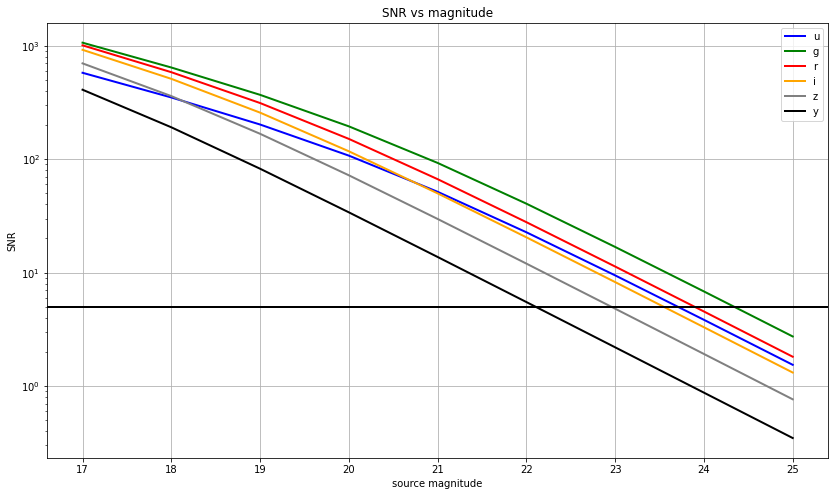

In [57]:
fig=plt.figure(figsize=(14,8))
ax=fig.add_subplot(1,1,1)

# loop on filters
for index in np.arange(6):
    
    neff_f=neff(index)
    sigmatot_f=sigmatot(index)

    all_Cb=Cb_m(index,magnitudes_sources)
    
    all_snr=SNR(all_Cb,sigmatot_f,neff_f)
    label=number_to_band_2[index]
    
    ax.plot(magnitudes_sources,all_snr,color=filtercolor[index],label=label,lw=2)
    
ax.set_yscale("log")
ax.grid()
ax.set_xlabel("source magnitude")
ax.set_ylabel("SNR")
ax.set_title("SNR vs magnitude")
ax.legend()
ax.axhline(y=5,color="k",lw=2)

## SNR vs magnitude

In [63]:
all_snr=np.logspace(-1,3,num=50,base=10)

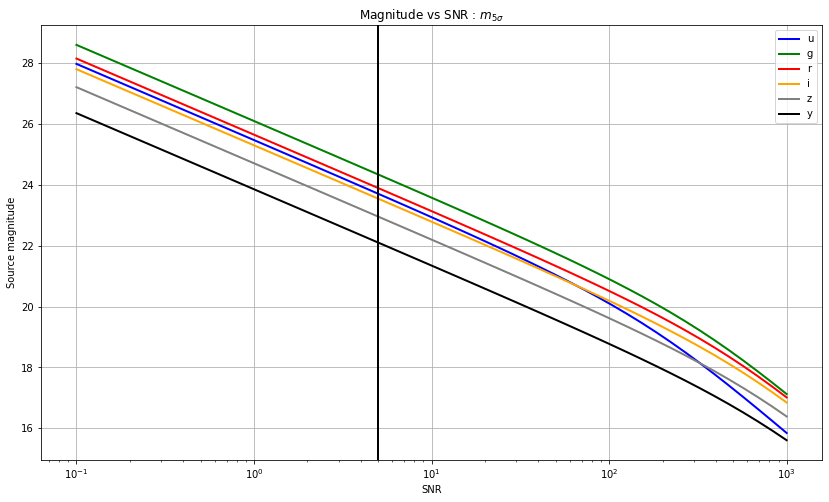

In [73]:
fig=plt.figure(figsize=(14,8))
ax=fig.add_subplot(1,1,1)

# loop on filters
for index in np.arange(6):
    
    neff_f=neff(index)
    sigmatot_f=sigmatot(index)

    all_Cb=Cb_snr(all_snr,sigmatot_f,neff_f)
      
    all_m=m_cb(index,all_Cb)
    label=number_to_band_2[index]
    
    ax.plot(all_snr,all_m,color=filtercolor[index],label=label,lw=2)
    
ax.set_xscale("log")
ax.grid()
ax.set_ylabel("Source magnitude")
ax.set_xlabel("SNR")
ax.set_title("Magnitude vs SNR : $m_{5\sigma}$")
ax.legend()
ax.axvline(x=5,color="k",lw=2)